<a href="https://colab.research.google.com/github/arzoozehra/CIND820/blob/main/unsupervised_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
!pip install contractions
import contractions
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
#!pip install pyspellchecker
#from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.losses import SparseCategoricalCrossentropy
from tensorflow.python.keras.optimizer_v2.adam import Adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**Load data**

In [2]:
url = "https://raw.githubusercontent.com/arzoozehra/CIND820/main/data/train.csv"
train = pd.read_csv(url)
test = pd.read_csv("https://raw.githubusercontent.com/arzoozehra/CIND820/main/data/test.csv")

train.drop(["textID", "selected_text"], axis=1, inplace=True)
test.drop(["textID"], axis=1, inplace=True)

# Remove row with missing values
train.dropna(inplace=True)

**Clean data**

In [3]:
def clean_data(data):
  
  # Convert text to lowercase
  data["text"] = data["text"].str.lower()

  # Expand contractions e.g "gonna" to "going to" and "i've" to "i have"
  data["text"].replace( {r"`": "'"}, inplace= True, regex = True)
  data["text"] = data["text"].apply(contractions.fix)

  # Remove @, Unicode characters, punctuation, emojis, URLs, retweets, words with digits, and 1 or 2 letter words
  data["text"].replace( {r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?|\w*\d\w*|\b\w{1,2}\b": " "}, inplace= True, regex = True)

  # Remove extra whitespaces
  data["text"].replace( {r" +": " "}, inplace= True, regex = True)
  data["text"] = data["text"].str.strip()

  # Correct spellings
  #spell = SpellChecker()

  #def correct_spellings(text):
  #    corrected_text = []
  #    misspelled_words = {}
  #    words = text.split()
  #    for w in spell.unknown(words):
  #        corr = spell.correction(w)
  #        if corr:
  #            misspelled_words[w] = spell.correction(w) or w
  #    corrected_text = [misspelled_words.get(w, w) for w in words]
  #    return " ".join(corrected_text)

  #data["text"] = data["text"].apply(lambda x : correct_spellings(x))

  # Remove stopwords
  stop = stopwords.words("english")
  data["text"] = data["text"].apply(lambda text: " ".join([word for word in text.split() if word not in (stop)]))

  # Stemming
  stemmer = PorterStemmer()
  data["text"] = data["text"].apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))

  # Lemmatizing
  lemmatizer = WordNetLemmatizer()
  data["text"] = data["text"].apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))

  return data

In [4]:
#Clean trraining data
train = clean_data(train)

#Clean testing data
test = clean_data(test)

In [5]:
def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes



**Feature Selection**

In [6]:
# Vectorization parameters

def ngram_vectorize(train_texts, train_labels, val_texts):
  """Vectorizes texts as ngram vectors.
  1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.
  # Arguments
      train_texts: list, training text strings.
      train_labels: np.ndarray, training labels.
      val_texts: list, validation text strings.
  # Returns
      x_train, x_val: vectorized training and validation texts
  """
  # Range (inclusive) of n-gram sizes for tokenizing text.
  # Use 1-grams + 2-grams.
  NGRAM_RANGE = (1, 2)

  # Whether text should be split into word or character n-grams.
  # Split text into word tokens.
  TOKEN_MODE = 'word'

  # Minimum document/corpus frequency below which a token will be discarded.
  MIN_DOCUMENT_FREQUENCY = 5

  # Create keyword arguments to pass to the 'tf-idf' vectorizer.
  kwargs = {
          "ngram_range": NGRAM_RANGE,
          "analyzer": TOKEN_MODE,  
          "min_df": MIN_DOCUMENT_FREQUENCY,
          "max_df" : 0.8,
          "sublinear_tf": "True"
  }
  vectorizer = TfidfVectorizer(**kwargs)

  # Learn vocabulary from training texts and vectorize training texts.
  x_train = vectorizer.fit_transform(train_texts).toarray()

  # Vectorize validation texts.
  x_val = vectorizer.transform(val_texts).toarray()

  return x_train, x_val

**Unsupervised modelling using TensorFlow**

In [7]:
def mlp_model(layers, units, dropout_rate, input_shape, op_units=3, op_activation='softmax'):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        op_units: int, number of output classes.
        op_activation: softmax for multiclass

    # Returns
        An MLP model instance.
    """

    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

**Train model**

In [59]:
def train_ngram_model(train, test,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.
    # Arguments
        train, test: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """

    # Get the data
    train_texts, val_texts, train_labels, val_labels = train_test_split(train["text"], train["sentiment"], test_size=0.2, random_state=42)

    # Encode train and test labels
    le = LabelEncoder()
    train_labels = le.fit_transform(train_labels)
    val_labels = le.fit_transform(val_labels)

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                          ' {unexpected_labels}. Please make sure that the '
                          'labels in the validation set are in the same range '
                          'as training labels.'.format(
                              unexpected_labels=unexpected_labels))


    # Vectorize texts.
    x_train, x_val = ngram_vectorize(train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                      units=units,
                      dropout_rate=dropout_rate,
                      input_shape=x_train.shape[1:])

    # Compile model with learning parameters.
    loss = 'sparse_categorical_crossentropy'
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [EarlyStopping(monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(x_train, train_labels,
                        epochs = epochs,
                        callbacks = callbacks,
                        validation_data = (x_val, val_labels),
                        verbose = 2,  # Logs once per epoch.
                        batch_size = batch_size
    )

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    #model.save('tfNN_model.h5')
    #return(history['val_acc'][-1], history['val_loss'][-1], model)
    return(history, model)

In [60]:
history, model = train_ngram_model(train, test)

Epoch 1/1000
172/172 - 3s - loss: 0.9950 - acc: 0.5193 - val_loss: 0.8572 - val_acc: 0.6448
Epoch 2/1000
172/172 - 2s - loss: 0.7821 - acc: 0.6749 - val_loss: 0.7587 - val_acc: 0.6790
Epoch 3/1000
172/172 - 2s - loss: 0.7084 - acc: 0.7026 - val_loss: 0.7419 - val_acc: 0.6821
Epoch 4/1000
172/172 - 2s - loss: 0.6658 - acc: 0.7244 - val_loss: 0.7443 - val_acc: 0.6810
Epoch 5/1000
172/172 - 2s - loss: 0.6454 - acc: 0.7313 - val_loss: 0.7505 - val_acc: 0.6785
Validation accuracy: 0.6784934401512146, loss: 0.7505127191543579


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 4636)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                296768    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 296,963
Trainable params: 296,963
Non-trainable params: 0
_________________________________________________________________


In [11]:
#model.get_config()

In [61]:
def tune_ngram_model(train, test):
    """Tunes n-gram model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
    """
    # Select parameter values to try.
    num_layers = [1, 2, 3]
    num_units = [16, 32, 64, 128]

    entries = []

    # Save parameter combination and results.
    params = {
        'layers': [],
        'units': [],
        'accuracy': [],
    }

    # Iterate over all parameter combinations.
    for layers in num_layers:
        for units in num_units:
                params['layers'].append(layers)
                params['units'].append(units)

                history, _= train_ngram_model(train=train,
                                                  test=test,
                                                  layers=layers,
                                                  units=units)
                accuracy = history['val_acc'][-1]
                entries.append({"Accuracy":accuracy, "Layers":layers, "Units":units})
                params['accuracy'].append(accuracy)
    _plot_parameters(params)
    return entries

In [13]:
def _plot_parameters(params):
    """Creates a 3D surface plot of given parameters.
    # Arguments
        params: dict, contains layers, units and accuracy value combinations.
    """
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(params['layers'],
                    params['units'],
                    params['accuracy'],
                    cmap="Blues",
                    antialiased=False)
    plt.show()


Epoch 1/1000
172/172 - 3s - loss: 1.0742 - acc: 0.4434 - val_loss: 1.0526 - val_acc: 0.4549
Epoch 2/1000
172/172 - 2s - loss: 1.0312 - acc: 0.4838 - val_loss: 1.0204 - val_acc: 0.4985
Epoch 3/1000
172/172 - 2s - loss: 0.9968 - acc: 0.5341 - val_loss: 0.9936 - val_acc: 0.5384
Epoch 4/1000
172/172 - 2s - loss: 0.9667 - acc: 0.5760 - val_loss: 0.9704 - val_acc: 0.5742
Epoch 5/1000
172/172 - 2s - loss: 0.9411 - acc: 0.6071 - val_loss: 0.9500 - val_acc: 0.5884
Epoch 6/1000
172/172 - 2s - loss: 0.9182 - acc: 0.6272 - val_loss: 0.9322 - val_acc: 0.6063
Epoch 7/1000
172/172 - 2s - loss: 0.8973 - acc: 0.6447 - val_loss: 0.9163 - val_acc: 0.6150
Epoch 8/1000
172/172 - 2s - loss: 0.8798 - acc: 0.6542 - val_loss: 0.9023 - val_acc: 0.6279
Epoch 9/1000
172/172 - 2s - loss: 0.8613 - acc: 0.6626 - val_loss: 0.8896 - val_acc: 0.6336
Epoch 10/1000
172/172 - 2s - loss: 0.8445 - acc: 0.6776 - val_loss: 0.8781 - val_acc: 0.6368
Epoch 11/1000
172/172 - 2s - loss: 0.8346 - acc: 0.6727 - val_loss: 0.8680 - va

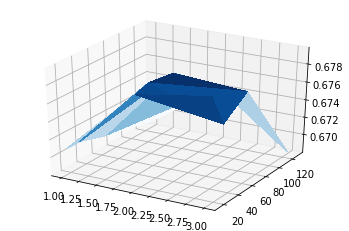

In [14]:
accuracies = tune_ngram_model(train, test)

In [15]:
print(accuracies)

[{'Accuracy': 0.6708515286445618, 'Layers': 1, 'Units': 16}, {'Accuracy': 0.6708515286445618, 'Layers': 1, 'Units': 32}, {'Accuracy': 0.669941782951355, 'Layers': 1, 'Units': 64}, {'Accuracy': 0.6686681509017944, 'Layers': 1, 'Units': 128}, {'Accuracy': 0.6783115267753601, 'Layers': 2, 'Units': 16}, {'Accuracy': 0.6788573265075684, 'Layers': 2, 'Units': 32}, {'Accuracy': 0.6784934401512146, 'Layers': 2, 'Units': 64}, {'Accuracy': 0.6741266250610352, 'Layers': 2, 'Units': 128}, {'Accuracy': 0.6795851588249207, 'Layers': 3, 'Units': 16}, {'Accuracy': 0.6759461164474487, 'Layers': 3, 'Units': 32}, {'Accuracy': 0.6779475808143616, 'Layers': 3, 'Units': 64}, {'Accuracy': 0.6681222915649414, 'Layers': 3, 'Units': 128}]


In [56]:
df = pd.DataFrame(accuracies)
print(df)
best = df[['Layers', 'Units']][df.Accuracy == df.Accuracy.max()]
best_layer = best["Layers"].array[0]
best_unit = best["Units"].array[0]
print(best_layer)
print(best_unit)

    Accuracy  Layers  Units
0   0.670852       1     16
1   0.670852       1     32
2   0.669942       1     64
3   0.668668       1    128
4   0.678312       2     16
5   0.678857       2     32
6   0.678493       2     64
7   0.674127       2    128
8   0.679585       3     16
9   0.675946       3     32
10  0.677948       3     64
11  0.668122       3    128
3
16


In [57]:
history, model = train_ngram_model(train, test, layers=best_layer, units=best_unit)

Epoch 1/1000
172/172 - 3s - loss: 1.0283 - acc: 0.4644 - val_loss: 0.8964 - val_acc: 0.5559
Epoch 2/1000
172/172 - 2s - loss: 0.8483 - acc: 0.6110 - val_loss: 0.7846 - val_acc: 0.6821
Epoch 3/1000
172/172 - 2s - loss: 0.7667 - acc: 0.6767 - val_loss: 0.7565 - val_acc: 0.6896
Epoch 4/1000
172/172 - 2s - loss: 0.7269 - acc: 0.6961 - val_loss: 0.7488 - val_acc: 0.6829
Epoch 5/1000
172/172 - 2s - loss: 0.6979 - acc: 0.7127 - val_loss: 0.7486 - val_acc: 0.6809
Epoch 6/1000
172/172 - 2s - loss: 0.6779 - acc: 0.7202 - val_loss: 0.7545 - val_acc: 0.6772
Epoch 7/1000
172/172 - 2s - loss: 0.6610 - acc: 0.7298 - val_loss: 0.7568 - val_acc: 0.6772
Validation accuracy: 0.677219808101654, loss: 0.756817638874054


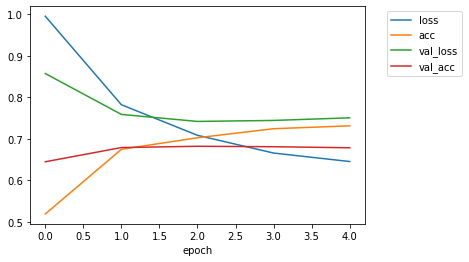

In [62]:
pd.DataFrame(history).plot()
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [71]:
le = LabelEncoder()
train_labels = le.fit_transform(train["sentiment"])
test_labels = le.fit_transform(test["sentiment"])


# Create keyword arguments to pass to the 'tf-idf' vectorizer.
kwargs = {
        "ngram_range": (1,2),
        "analyzer": "word",  
        "min_df": 5,
        "max_df" : 0.8,
        "sublinear_tf": "True"
}
vectorizer = TfidfVectorizer(**kwargs)

# Learn vocabulary from training texts and vectorize training texts.
x_train = vectorizer.fit_transform(train["text"]).toarray()

# Vectorize validation texts.
x_test = vectorizer.transform(test["text"]).toarray()

In [72]:
y = model.predict(x_test)

ValueError: ignored

In [17]:
# from tensorflow.keras.utils import plot_model
# plot(model, to_file='tfNN_model.png')